In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can choose any seed value

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [3]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [4]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, initial_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Set initial number of input channels after first conv layer

        # Initial dynamic and selective convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Construct the layers of the ResNet using the block definitions
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=50).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [8]:
batch_size = 16
input_shape = (batch_size, 3, 84, 84)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  21.3 M  
fwd MACs:                                                               35.0444 GMACs
fwd FLOPs:                                                              70.1987 GFLOPS
fwd+bwd MACs:                                                           105.133 GMACs
fwd+bwd FLOPs:                                                          210.596 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mo

/home/re6125015/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 3.3007 Train Acc: 12.92% Val Loss: 3.0626 Val Acc: 15.78%
Epoch 2: Train Loss: 2.8100 Train Acc: 21.89% Val Loss: 2.7229 Val Acc: 24.00%
Epoch 3: Train Loss: 2.4973 Train Acc: 28.82% Val Loss: 2.5274 Val Acc: 25.56%
Epoch 4: Train Loss: 2.2650 Train Acc: 34.41% Val Loss: 2.2043 Val Acc: 36.22%
Epoch 5: Train Loss: 2.0656 Train Acc: 39.24% Val Loss: 2.1591 Val Acc: 36.67%
Epoch 6: Train Loss: 1.8905 Train Acc: 43.87% Val Loss: 2.2800 Val Acc: 35.78%
Epoch 7: Train Loss: 1.7445 Train Acc: 47.62% Val Loss: 1.8640 Val Acc: 44.00%
Epoch 8: Train Loss: 1.6045 Train Acc: 51.09% Val Loss: 1.8554 Val Acc: 44.67%
Epoch 9: Train Loss: 1.4783 Train Acc: 54.61% Val Loss: 1.7823 Val Acc: 50.00%
Epoch 10: Train Loss: 1.3813 Train Acc: 57.22% Val Loss: 1.6410 Val Acc: 52.67%
Epoch 11: Train Loss: 1.2870 Train Acc: 59.73% Val Loss: 1.8839 Val Acc: 47.33%
Epoch 12: Train Loss: 1.2020 Train Acc: 62.07% Val Loss: 1.8746 Val Acc: 48.22%
Epoch 13: Train Loss: 1.1231 Train Acc: 64.14% Va

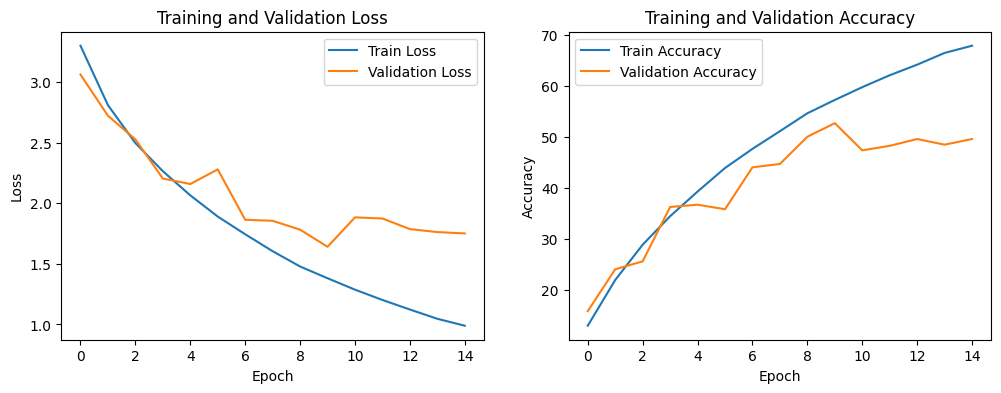

In [8]:
num_epochs = 50
early_stopping_counter = 0
best_val_loss = float('inf')

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'part2/resnet34_{res}.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 4:  # Stops if no improvement after 4 epochs
        print("Early stopping triggered.")
        break

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [9]:
print(best_val_loss)

1.6409886320432028


In [10]:
model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=50)  # Ensure this matches the model architecture
model.load_state_dict(torch.load(f'part2/resnet34_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Function to make predictions and optionally evaluate the model
def predict(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Get predictions and labels
predictions, labels = predict(model, test_loader)

In [12]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 51.78%


In [13]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'part2/predict_resnet34_{res}.csv', index=False)

In [14]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.11      0.12         9
           1       0.45      0.56      0.50         9
           2       0.62      0.56      0.59         9
           3       0.60      1.00      0.75         9
           4       0.78      0.78      0.78         9
           5       0.75      0.33      0.46         9
           6       0.83      0.56      0.67         9
           7       0.57      0.44      0.50         9
           8       0.40      0.44      0.42         9
           9       0.30      0.33      0.32         9
          10       0.29      0.22      0.25         9
          11       0.00      0.00      0.00         9
          12       1.00      0.56      0.71         9
          13       0.27      0.44      0.33         9
          14       0.57      0.44      0.50         9
          15       0.67      0.44      0.53         9
          16       0.33      0.22      0.27         9
    

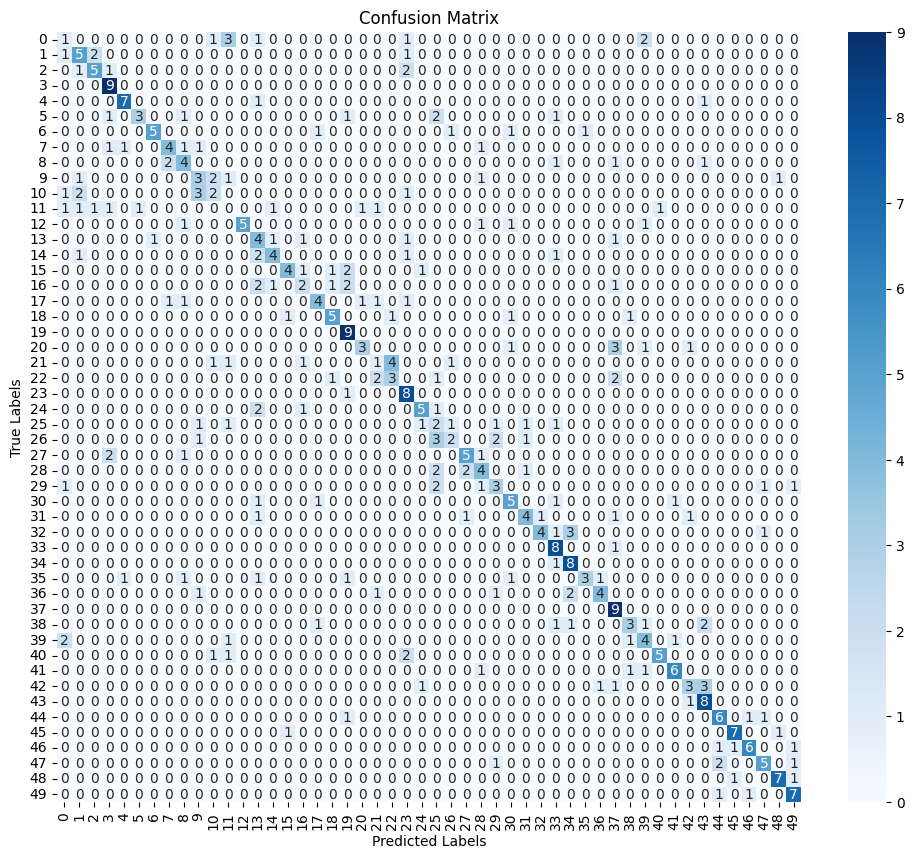

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()